In [1]:
import albumentations as A
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import os
import random
from collections import defaultdict
from glob import glob

c:\Users\rusla\OneDrive\Desktop\ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# важно - зафиксировать все сиды
SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class_to_idx = { "Апельсин": 0,
                 "Бананы": 1,
                 "Груши": 2, 
                 "Кабачки": 3, 
                 "Капуста": 4, 
                 "Картофель": 5, 
                 "Киви": 6, 
                 "Лимон": 7, 
                 "Лук": 8, 
                 "Мандарины": 9, 
                 "Морковь": 10, 
                 "Огурцы": 11, 
                 "Томаты": 12, 
                 "Яблоки зелёные": 13, 
                 "Яблоки красные": 14 }

In [ ]:
class MyDataset(Dataset):
    def __init__(self, images_filepaths, name2label, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform
        self.name2label = name2label

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imdecode(np.fromfile(image_filepath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.name2label[os.path.normpath(image_filepath).split(os.sep)[-3]]
        if self.transform is not None:
            image = self.transform(image=image)['image']
        return image, label


def train_test_split_from_directory(root_path, folder2class, train_size=0.8):
    train, test = [], []
    # class_to_images = defaultdict(list)

    for class_name in os.listdir(root_path):
        class_path = os.path.join(root_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for subclass_name in os.listdir(class_path):
            subclass_path = os.path.join(class_path, subclass_name)
            if not os.path.isdir(subclass_path):
                continue

            # Глобальный класс = имя первой папки (class_name)
            # class_name = folder2class.get(class_name, class_name)

            images = glob(os.path.join(subclass_path, '*.jpg')) + \
                     glob(os.path.join(subclass_path, '*.png')) + \
                     glob(os.path.join(subclass_path, '*.jpeg'))
            
            if len(images) == 0:
                continue
            
            # делим подклассы в пропорции 80/20
            random.shuffle(images)
            split_idx = int(train_size * len(images))

            if split_idx == 0 and len(images) > 0:
                split_idx = 1

            train.extend(images[:split_idx])
            test.extend(images[split_idx:])

            # class_to_images[class_name].extend(images)

    # Равномерное разбиение по каждому классу
    # for cls_name, images in class_to_images.items():
    #     random.shuffle(images)
    #     split_idx = int(train_size * len(images))
    #     train.extend(images[:split_idx])
    #     test.extend(images[split_idx:])

    random.shuffle(train)
    random.shuffle(test)

    return train, test


In [5]:
dataset_path = 'train/train'
train, test = train_test_split_from_directory(dataset_path, class_to_idx)

# Посмотрим на распределение данных

In [6]:
from collections import Counter
import os

def count_classes(image_paths, class_to_idx):
    counts = Counter()
    for im_path in image_paths:
        class_name = os.path.normpath(im_path).split(os.sep)[-3]
        class_idx = class_to_idx[class_name]
        counts[class_idx] += 1
    return counts

train_counts = count_classes(train, class_to_idx)
test_counts  = count_classes(test, class_to_idx)


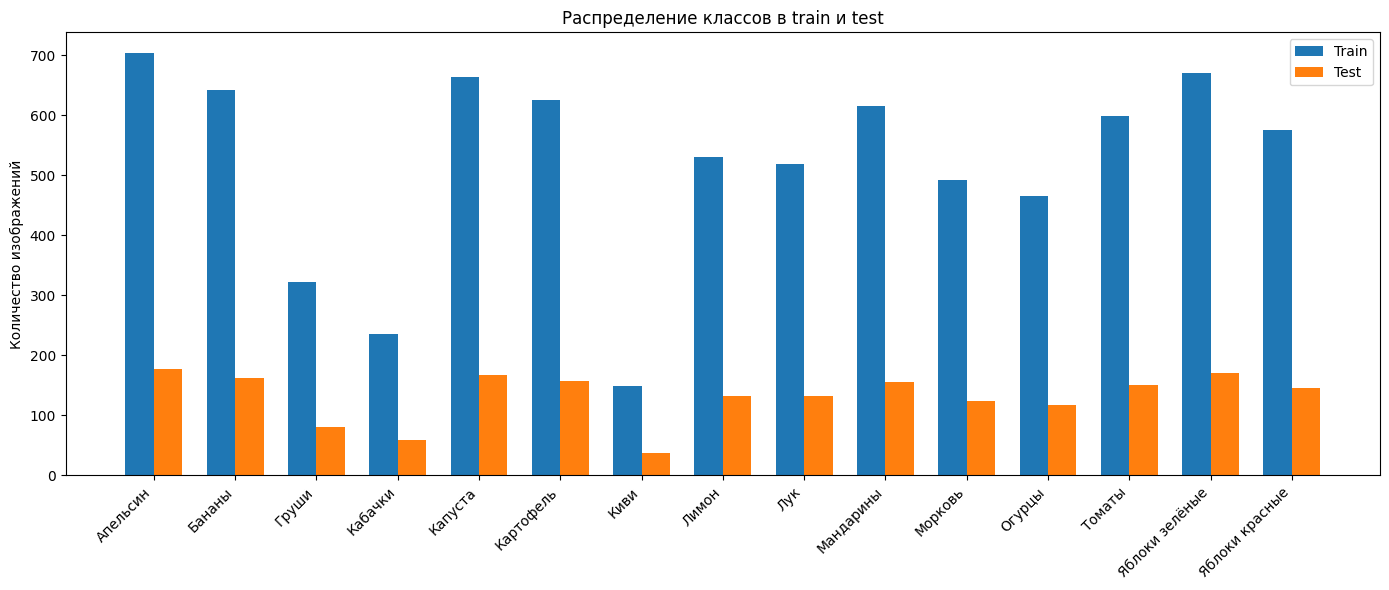

In [7]:
import matplotlib.pyplot as plt
import numpy as np

idx2class = {v: k for k, v in class_to_idx.items()}

classes = list(idx2class.keys())
class_names = [idx2class[i] for i in classes]

train_values = [train_counts.get(i, 0) for i in classes]
test_values  = [test_counts.get(i, 0) for i in classes]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, train_values, width, label='Train')
plt.bar(x + width/2, test_values,  width, label='Test')

plt.xticks(x, class_names, rotation=45, ha='right')
plt.ylabel('Количество изображений')
plt.title('Распределение классов в train и test')
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

rows = []

for class_idx, class_name in idx2class.items():
    train_cnt = train_counts.get(class_idx, 0)
    test_cnt  = test_counts.get(class_idx, 0)
    total     = train_cnt + test_cnt

    test_ratio = test_cnt / total if total > 0 else 0

    rows.append({
        "Класс": class_name,
        "Train": train_cnt,
        "Test": test_cnt,
        "Total": total,
        "Test %": round(test_ratio * 100, 2)
    })

df = pd.DataFrame(rows)
df


,Класс,Train,Test,Total,Test %
0,Апельсин,703,177,880,20.11
1,Бананы,642,162,804,20.15
2,Груши,322,81,403,20.10
3,Кабачки,235,59,294,20.07
4,Капуста,663,168,831,20.22
5,Картофель,626,158,784,20.15
6,Киви,149,38,187,20.32
7,Лимон,531,133,664,20.03
8,Лук,518,132,650,20.31
9,Мандарины,615,156,771,20.23


# Вернёмся к обучению

### Аугментации - базовая техника для увеличения набора данных

In [9]:
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Validation transforms - deterministic
val_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [10]:
train_dataset = MyDataset(images_filepaths=train, name2label=class_to_idx, transform=train_transforms)
test_dataset = MyDataset(images_filepaths=test, name2label=class_to_idx, transform=val_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,  # Parallel loading
    pin_memory=True,  # Faster GPU transfer
    persistent_workers=False  # Keep workers alive
)
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,  # Parallel loading
    pin_memory=True,  # Faster GPU transfer
    persistent_workers=False
    )

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")

Функция оценки нашей модели

In [14]:
from tqdm import tqdm # progress bar

@torch.no_grad() # при вызове функции отключаем калькулятор градиентов
def evaluate(model, dataloader, loss_fn, device, desc="Val"):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(dataloader, desc=desc, leave=False)
    for X_batch, y_batch in pbar:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)

        batch_size = y_batch.size(0)
        total_loss += loss.item() * batch_size

        y_pred = logits.argmax(dim=1)
        total_correct += (y_pred == y_batch).sum().item()
        total_samples += batch_size

        avg_loss = total_loss / max(total_samples, 1)
        acc = total_correct / max(total_samples, 1)
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.4f}")

    avg_loss = total_loss / max(total_samples, 1)
    accuracy = total_correct / max(total_samples, 1)
    return accuracy, avg_loss


def train(model, loss_fn, optimizer, train_loader, val_loader, device, writer=None, n_epoch=3):
    num_iter = 0

    for epoch in range(1, n_epoch + 1):
        model.train()

        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{n_epoch}", leave=True)

        for X_batch, y_batch in pbar:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            # накопим метрики для прогресс-бара
            batch_size = y_batch.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            y_pred = logits.argmax(dim=1)
            total_correct += (y_pred == y_batch).sum().item()

            avg_loss = total_loss / max(total_samples, 1)
            acc = total_correct / max(total_samples, 1)

            # tqdm live-metrics
            pbar.set_postfix(train_loss=f"{avg_loss:.4f}", train_acc=f"{acc:.4f}")

            # логирование (по итерациям)
            num_iter += 1
            if writer is not None:
                writer.add_scalar("Loss/train", loss.item(), num_iter)
                writer.add_scalar("Accuracy/train", (y_pred == y_batch).float().mean().item(), num_iter)

        # Валидация (тоже с tqdm)
        val_acc, val_loss = evaluate(model, val_loader, loss_fn, device, desc=f"Val {epoch}/{n_epoch}")

        if writer is not None:
            writer.add_scalar("Loss/val", val_loss, num_iter)
            writer.add_scalar("Accuracy/val", val_acc, num_iter)

        print(f"Epoch {epoch}/{n_epoch}: val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

    return model


## Три основные составляющие любого обучения:
### 1) Модель
### 2) Функция ошибок (loss function)
### 3) Оптимизатор

In [15]:
model = timm.create_model('resnet18', pretrained=True, num_classes=15)
model.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\rusla\OneDrive\Desktop\ML\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rusla\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
model = train(model, loss_fn, optimizer, train_loader, test_loader, device, writer, n_epoch=10)

Epoch 1/10:   0%|          | 0/244 [00:00<?, ?it/s]c:\Users\rusla\OneDrive\Desktop\ML\.venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
Epoch 1/10: 100%|██████████| 244/244 [12:19<00:00,  3.03s/it, train_acc=0.4843, train_loss=1.5623]


Epoch 1/10: val_loss=0.7833  val_acc=0.7666


Epoch 2/10: 100%|██████████| 244/244 [09:51<00:00,  2.42s/it, train_acc=0.6747, train_loss=0.9809]


Epoch 2/10: val_loss=0.5634  val_acc=0.8077


Epoch 3/10: 100%|██████████| 244/244 [10:11<00:00,  2.51s/it, train_acc=0.7365, train_loss=0.7875]


Epoch 3/10: val_loss=0.5312  val_acc=0.8331


Epoch 4/10:  88%|████████▊ | 215/244 [09:21<01:16,  2.64s/it, train_acc=0.7765, train_loss=0.6618]

# Посмотрим на итоговые метрики

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

@torch.no_grad()
def sklearn_report(model, dataloader, device, idx2class=None, digits=4):
    model.eval()

    y_true, y_pred = [], []

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device, non_blocking=True)

        logits = model(X_batch)
        preds = logits.argmax(dim=1).cpu().numpy()

        y_pred.append(preds)
        y_true.append(y_batch.numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # names for report
    if idx2class is None:
        target_names = None
        labels = None
    else:
        labels = sorted(idx2class.keys())
        target_names = [idx2class[i] for i in labels]

    rep = classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=target_names,
        digits=digits,
        zero_division=0
    )
    print(rep)

In [ ]:
sklearn_report(model, test_loader, device, idx2class=idx2class)

# Оформляем предсказание

In [ ]:
test_images_dir = "test_images/test_images"
submission_path = "sample_submission.csv"
output_path = "submission.csv"

In [ ]:
submission = pd.read_csv(submission_path)

model.eval()
pred_labels = []

with torch.no_grad():
    for image_id in tqdm(submission["image_id"], desc="Predicting"):
        image_path = os.path.join(test_images_dir, image_id)

        image = cv2.imdecode(
            np.fromfile(image_path, dtype=np.uint8),
            cv2.IMREAD_COLOR
        )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Когда мы хотим сделать предсказание, нам нужно знать, а какие были преобразования при обучении/тестировании
        if val_transforms is not None:
            image = val_transforms(image=image)["image"]

        image = image.unsqueeze(0).to(device)

        logits = model(image)
        pred_idx = logits.argmax(dim=1).item()

        pred_labels.append(pred_idx)


In [ ]:
submission["label"] = pred_labels
submission.to_csv(output_path, index=False)

submission.head()
